<a href="https://colab.research.google.com/github/sherki99/GoFinance_one/blob/master/deep_learning_%20MOD006565.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
from pandas.core.internals.managers import create_block_manager_from_column_arrays
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier   

from pandas.core.internals.managers import create_block_manager_from_column_arrays
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier     # make my cmodle compatile with scikit-learn 
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

#### Data Preprocessing



Data pre-processing: The first step is to clean and prepare the data. This includes handling missing values, scaling the data, converting categorical data to numerical data (if necessary), and splitting the data into training, validation, and testing sets.

In [ ]:
dt = pd.read_csv("/content/diabetes.csv")
dt = pd.DataFrame(dt)
print("The shape of this dataframe is " , dt.shape)
dt.head()

The shape of this dataframe is  (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##### Checking any missing values

In [ ]:
## check if there are any missing values ## no  null value in dt
dt.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#####Check any outliers

In [ ]:
# caculate the meabn and standard devation 

mean = dt.mean()
stddev = dt.std()



# define z-score
def z_score(x): 
  return (x- x.mean()) / x.std()


# apply the z-score function to each column of the dataframe
z_scores = dt.apply(z_score)

print("Z-scores " ,z_scores )


# After calculating the z-score for each value in the dataframe, I can use it to identify the outliers in the data. Usually, a z-score greater than 3 or less than -3 is considered as an outlier.
outliers = dt[(z_scores > 3) | (z_scores < -3)].count()
print(outliers)


Z-scores       Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.639530  0.847771       0.149543       0.906679 -0.692439  0.203880   
1      -0.844335 -1.122665      -0.160441       0.530556 -0.692439 -0.683976   
2       1.233077  1.942458      -0.263769      -1.287373 -0.692439 -1.102537   
3      -0.844335 -0.997558      -0.160441       0.154433  0.123221 -0.493721   
4      -1.141108  0.503727      -1.503707       0.906679  0.765337  1.408828   
..           ...       ...            ...            ...       ...       ...   
763     1.826623 -0.622237       0.356200       1.721613  0.869464  0.115094   
764    -0.547562  0.034575       0.046215       0.405181 -0.692439  0.609757   
765     0.342757  0.003299       0.149543       0.154433  0.279412 -0.734711   
766    -0.844335  0.159683      -0.470426      -1.287373 -0.692439 -0.240048   
767    -0.844335 -0.872451       0.046215       0.655930 -0.692439 -0.201997   

     DiabetesPedigreeFunction

##### standardize and scale data

In [ ]:
# separate the features from the target variable
X = dt.iloc[:,:-1]
y = dt.iloc[:, -1]


##  feauture scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(X)

## convert y into array
y = np.array(y).reshape(-1,1)


# update the original dataframe with staandriazitoon 
dt[X.columns] = x
dt.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1


In [ ]:
import pandas as pd

summary_status  =dt.describe().head()
print(summary_status)

        Pregnancies       Glucose  BloodPressure  SkinThickness       Insulin  \
count  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02  7.680000e+02   
mean  -6.476301e-17 -9.251859e-18   1.503427e-17   1.006140e-16 -3.006854e-17   
std    1.000652e+00  1.000652e+00   1.000652e+00   1.000652e+00  1.000652e+00   
min   -1.141852e+00 -3.783654e+00  -3.572597e+00  -1.288212e+00 -6.928906e-01   
25%   -8.448851e-01 -6.852363e-01  -3.673367e-01  -1.288212e+00 -6.928906e-01   

                BMI  DiabetesPedigreeFunction           Age     Outcome  
count  7.680000e+02              7.680000e+02  7.680000e+02  768.000000  
mean   2.590520e-16              2.451743e-16  1.931325e-16    0.348958  
std    1.000652e+00              1.000652e+00  1.000652e+00    0.476951  
min   -4.060474e+00             -1.189553e+00 -1.041549e+00    0.000000  
25%   -5.955785e-01             -6.889685e-01 -7.862862e-01    0.000000  


####Data visualization

 Data visualization: It is important to visualize the data to gain insights and identify patterns. This includes creating histograms, scatter plots, and correlation matrices.

##### Histogram

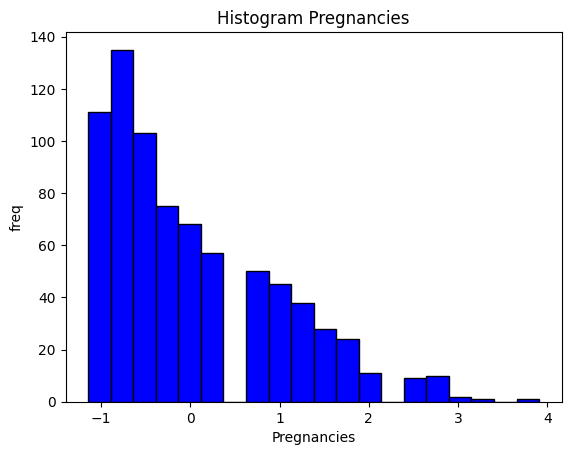

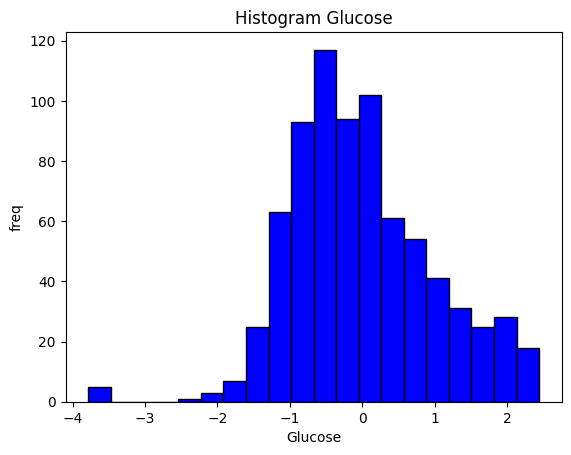

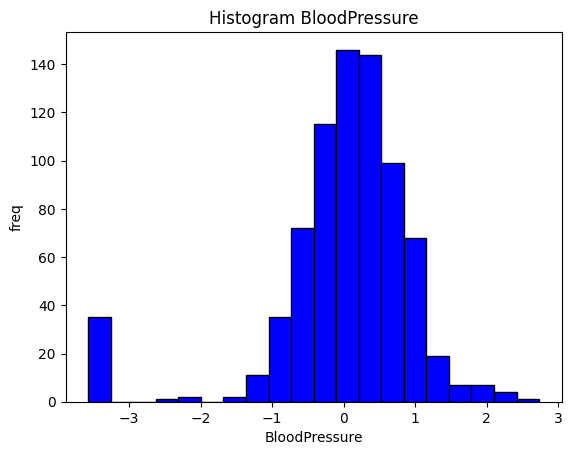

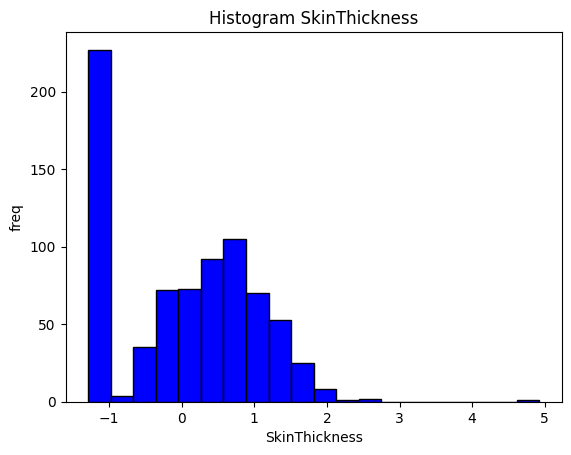

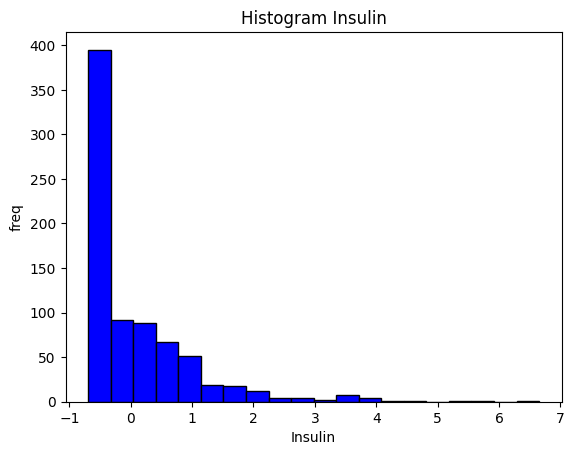

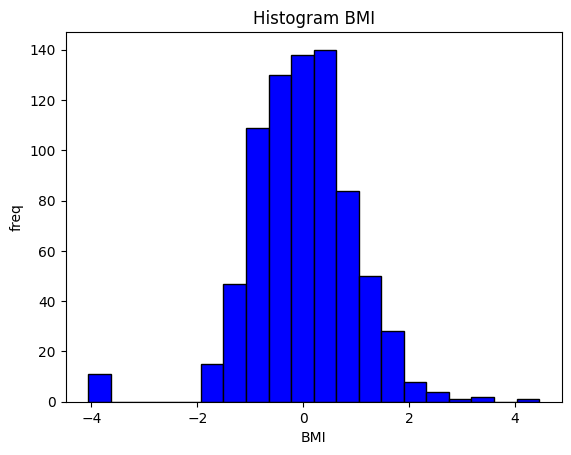

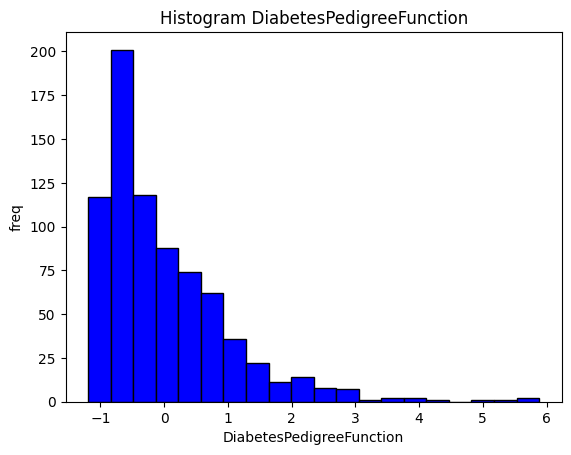

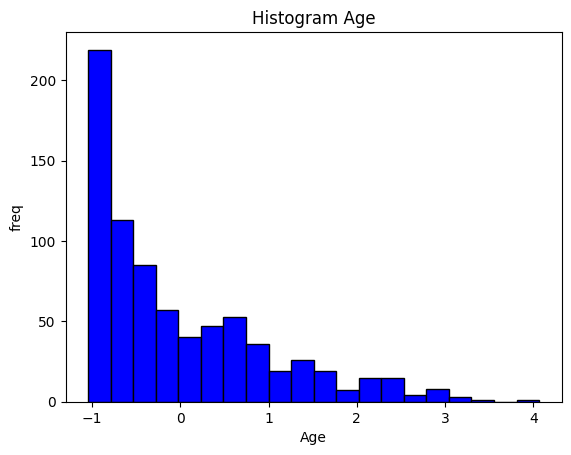

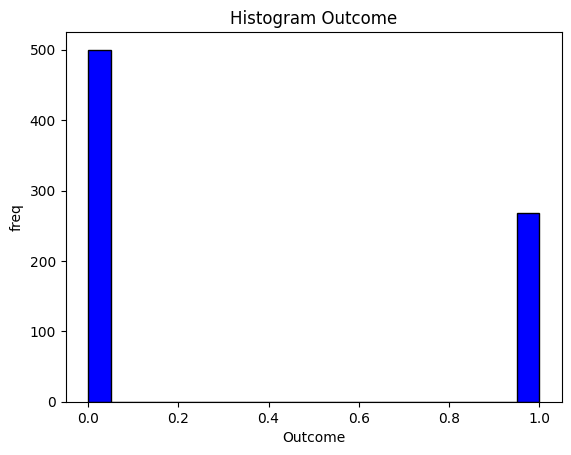

In [ ]:
import matplotlib.pyplot as plt 


## histogram
for i in range(len(dt.columns)):
  column_name = dt.columns[i]
  column_data = dt.iloc[:, i]
  hist = plt.hist(column_data, bins = 20,color = "blue",edgecolor = "black")
  plt.xlabel(column_name)
  plt.ylabel("freq")
  plt.title("Histogram " + column_name )
  plt.show()

##### Corrrelation matrix 

In [ ]:
import seaborn as sns

## correlation matrix
corr_matrix = dt.corr()

sns.heatmap(corr_matrix, annot= True,cmap = "coolwarm")

#display the correlation matrix
plt.show()

####   splitting the train set and test test

In [ ]:
## spliting and train set with the validation set 
from sklearn.model_selection import train_test_split

#  (80/20 split)
x_train , x_test , y_train, y_test = train_test_split(x, y, test_size  = 0.2 , random_state = 42 )

# Split the training data into training and validation sets (90/10 split)

x_train, x_val, y_train , y_val = train_test_split(x_train, y_train , test_size  = 0.2, random_state = 42)

print("train shape: " , x_train.shape )
print("test shape:  " , x_test.shape)
print("val shaape: ", x_val.shape )


# REEMBER DO NO TRUN CNN IF YOU WANT TO RUN THE OTHERS

train shape:  (491, 8)
test shape:   (154, 8)
val shaape:  (123, 8)


## Models

###Deep Feed Forward


In [ ]:
model_one = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation = "relu", input_shape= (8,), kernel_regularizer= tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu",  kernel_regularizer= tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = "relu",  kernel_regularizer= tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [ ]:
# early stopping to stop training when the validation loss stops improving
#early_stopping= tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 100)


model_one.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_one.fit(x_train, y_train, epochs = 100, validation_data = (x_val, y_val))


In [ ]:
print(model_one.predict([[-0.84488505, -0.8730192 ,  0.04624525,  0.65635768, -0.69289057,
       -0.20212881, -0.47378505, -0.87137393]]))

1/1 [==============================] - 0s 84ms/step
[[0.03719604]]


In [ ]:
##predicting the test set result

y_pred  = model_one.predict(x_test)
y_pred = (y_pred > 0.5)
print(y_pred[:10])

print(y_pred.shape, y_test.shape)

5/5 [==============================] - 0s 2ms/step
[[ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]]
(154, 1) (154, 1)


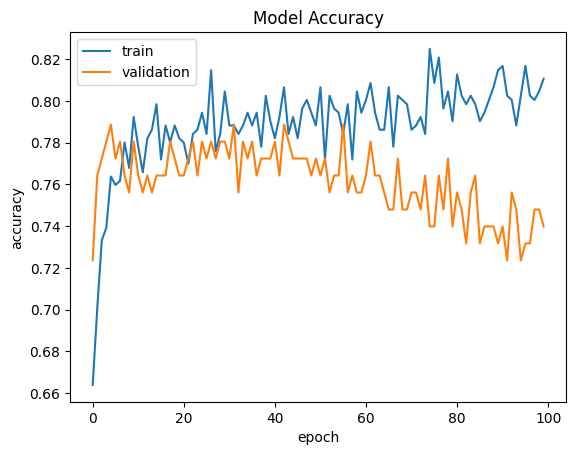

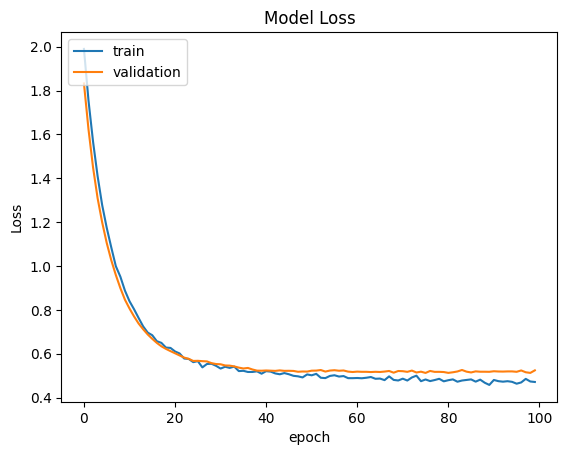

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()
#plt.plot()

A confusion matrix is a technique for summarizing the performance of a classification algorithm.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making

The confusion matrix shows the ways in which your classification model
is confused when it makes predictions.

5/5 [==============================] - 0s 4ms/step


 the confussion of matrix of this model is
 [[74 25]
 [19 36]] 



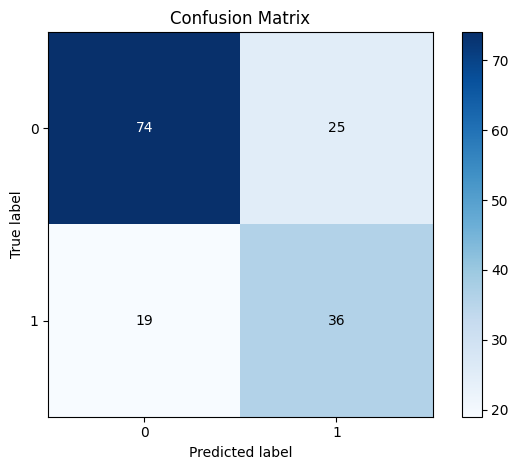




The Accurancy score is  0.7142857142857143


In [ ]:
y_pred = model_one.predict(x_test) 
y_pred = y_pred  > 0.5
y_pred = y_pred.astype(int)
y_pred = y_pred.reshape(-1,1)
y_test = y_test.astype(int)



## confussion matrix 
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)

print("\n\n the confussion of matrix of this model is\n" , cm ,"\n")

# forse lo lelimino ueta parte di codice 
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()



ac = accuracy_score(y_test, y_pred)
print("\n\n\nThe Accurancy score is " , ac) 

In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)




Precision: 0.5901639344262295
Recall: 0.6545454545454545
F1-score: 0.6206896551724138


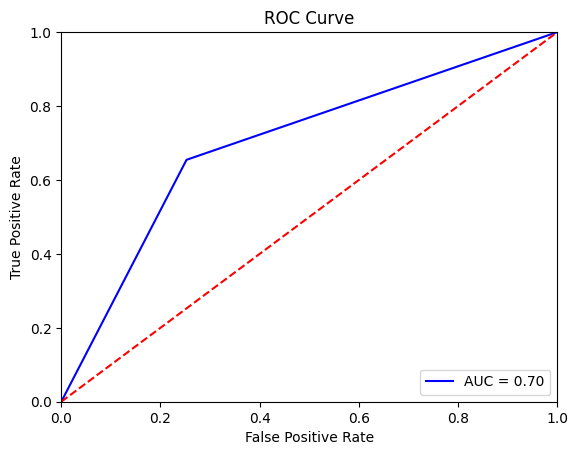

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# fpr = false positive rate, trp  =true positviet rate and also called recall
fpr, tpr, threholds = roc_curve(y_test, y_pred)
roc_auc =roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

###**CNN_model**


In [ ]:
x_train

array([[-0.25095213,  0.22238089,  0.45982725, ..., -1.3824778 ,
        -0.61573063,  1.85143417],
       [ 0.04601433, -0.81042491, -0.47073225, ...,  0.43246741,
        -0.56740873, -0.44593516],
       [-0.84488505,  1.31778097,  0.14964075, ...,  0.8893767 ,
         2.26546259, -0.0204964 ],
       ...,
       [-0.54791859, -0.96691063, -0.05715025, ...,  0.7878413 ,
         0.09399726, -0.53102292],
       [ 0.3429808 , -0.15318486,  0.25303625, ...,  0.03901775,
         0.56815589,  0.14967911],
       [ 0.04601433, -0.15318486,  0.14964075, ..., -1.25555855,
        -0.02680749,  0.31985461]])

In [ ]:
## pre processing the data, convert  th einput data into a suistable format for feeding into cnn, 
#convert the dat into 2d image like format
## I  use a technique called tabular data image embedding.

#### becuase I want to convert the data into 2d image I will pre-preocess the data differntly
## il ocnceto qui e qullo di transofrmare i fuoter in un image 2d on i loro label 
dt_cnn = pd.read_csv("/content/diabetes.csv")
# feauture scaling
dt_cnn = np.array(dt_cnn)
dt_cnn_feuteres  =  dt_cnn[:,:-1]

#from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
dt_cnn_feuteres = sc.fit_transform(dt_cnn_feuteres)
dt_cnn_image = dt_cnn_feuteres.reshape(-1 ,8 , 1) ## reshaspe the image in order to have 2D image// una linea 
print(dt_cnn_feuteres[:10])


## reshape the  data 
dt_cnn_label = dt_cnn[:, -1].reshape(-1, 1)
print(dt_cnn_label[:10])


[[ 0.63994726  0.84832379  0.14964075  0.90726993 -0.69289057  0.20401277
   0.46849198  1.4259954 ]
 [-0.84488505 -1.12339636 -0.16054575  0.53090156 -0.69289057 -0.68442195
  -0.36506078 -0.19067191]
 [ 1.23388019  1.94372388 -0.26394125 -1.28821221 -0.69289057 -1.10325546
   0.60439732 -0.10558415]
 [-0.84488505 -0.99820778 -0.16054575  0.15453319  0.12330164 -0.49404308
  -0.92076261 -1.04154944]
 [-1.14185152  0.5040552  -1.50468724  0.90726993  0.76583594  1.4097456
   5.4849091  -0.0204964 ]
 [ 0.3429808  -0.15318486  0.25303625 -1.28821221 -0.69289057 -0.81134119
  -0.81807858 -0.27575966]
 [-0.25095213 -1.34247638 -0.98770975  0.71908574  0.07120427 -0.12597727
  -0.676133   -0.61611067]
 [ 1.82781311 -0.184482   -3.57259724 -1.28821221 -0.69289057  0.41977549
  -1.02042653 -0.36084741]
 [-0.54791859  2.38188392  0.04624525  1.53455054  4.02192191 -0.18943689
  -0.94794368  1.68125866]
 [ 1.23388019  0.12848945  1.39038675 -1.28821221 -0.69289057 -4.06047387
  -0.7244549   1.7

(491, 8, 1)
(491, 1) 

 (154, 8, 1) (154, 1)


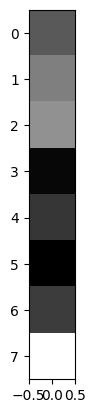

In [ ]:
## visuale the data 
import matplotlib.pyplot as plt 


x_train = x_train.reshape(-1 ,8 , 1) 
x_test = x_test.reshape(-1 ,8 , 1) 
x_val = x_val.reshape(-1 ,8 , 1) 

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)


print(x_train.shape)
print(y_train.shape , "\n\n", x_test.shape, y_test.shape)


plt.imshow(x_train[0], cmap = "gray")
plt.show()


# split the data
## spliting the training , validtion, nad testitng 
x_train , x_test , y_train, y_test = train_test_split(dt_cnn_image, dt_cnn_label, test_size  = 0.2 , random_state = 42 )
## validation test
x_train, x_val, y_train , y_val = train_test_split(x_train, y_train , test_size  = 0.2, random_state = 42)


#### Build CNN Model


In [ ]:

def create_cnn_model(num_layers = 2, activation = "relu", loss = "binary_crossentropy"): 
    model_cnn = tf.keras.models.Sequential()
    model_cnn.add(tf.keras.layers.Conv1D(64, (3), input_shape =(8, 1), activation =  activation))
    model_cnn.add(tf.keras.layers.MaxPool1D(pool_size= 2))
    model_cnn.add(tf.keras.layers.Conv1D(32, (3),activation = activation))
    model_cnn.add(tf.keras.layers.Flatten())
    model_cnn.add(tf.keras.layers.Dropout(0.2))
    model_cnn.add(tf.keras.layers.Dense(128, activation = activation))
    model_cnn.add(tf.keras.layers.Dense(1, activation = "sigmoid"))
    ## compile the model 
    model_cnn.compile( optimizer = "adam",loss = loss , metrics = ["accuracy"])
    return model_cnn



model_cnn = KerasClassifier(build_fn = create_cnn_model)

hyperparamter = {"batch_size":  [16, 32, 64],
                 "loss": ['binary_crossentropy', 'mse'], 
                 "activation": ["relu", "tanh"]}

               

grid_search = GridSearchCV(estimator = model_cnn , param_grid=hyperparamter, cv = 5, scoring = "accuracy" )



history  = grid_search.fit(x_train, y_train , validation_data = (x_val, y_val))


<ipython-input-91-f0eee2df9daf>:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_cnn = KerasClassifier(build_fn = create_cnn_model)


1/7 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.3438

1/7 [===>..........................] - ETA: 9s - loss: 0.6954 - accuracy: 0.4844

31/31 [==============================] - 2s 13ms/step - loss: 0.2035 - accuracy: 0.6986 - val_loss: 0.1524 - val_accuracy: 0.7886


In [ ]:

# print the best hyperparameters and their corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'activation': 'tanh', 'batch_size': 16, 'loss': 'mse'}
Best score: 0.7351473922902494


In [ ]:
#results = pd.DataFrame(grid_search.cv_results_)
#print(results[['params', 'mean_test_score', 'std_test_score']])

In [ ]:
## this is the code  using te best hyperparameter find by the gridview


model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, (3), input_shape =(8, 1), activation =  "tanh"),
    tf.keras.layers.MaxPool1D(pool_size= 2),
    tf.keras.layers.Conv1D(32, (3),activation =  "tanh"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation = "tanh"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])


## compile the model 
model_cnn.compile(optimizer = Adam(learning_rate = 0.0001) , loss = "binary_crossentropy", metrics = ["accuracy"])

history  = model_cnn.fit(x_train, y_train, epochs = 100, batch_size = 16, validation_data = (x_val, y_val))


Epoch 1/100
31/31 [==============================] - 3s 24ms/step - loss: 0.6755 - accuracy: 0.6049 - val_loss: 0.6490 - val_accuracy: 0.7073
Epoch 2/100
31/31 [==============================] - 0s 13ms/step - loss: 0.6353 - accuracy: 0.7128 - val_loss: 0.6089 - val_accuracy: 0.7480
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.5997 - accuracy: 0.7291 - val_loss: 0.5762 - val_accuracy: 0.7480
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.5672 - accuracy: 0.7413 - val_loss: 0.5477 - val_accuracy: 0.7642
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.5528 - accuracy: 0.7149 - val_loss: 0.5264 - val_accuracy: 0.7724
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 0.5371 - accuracy: 0.7413 - val_loss: 0.5129 - val_accuracy: 0.7805
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 0.5263 - accuracy: 0.7373 - val_loss: 0.5018 - val_accuracy: 0.7967
Epoch 8/1

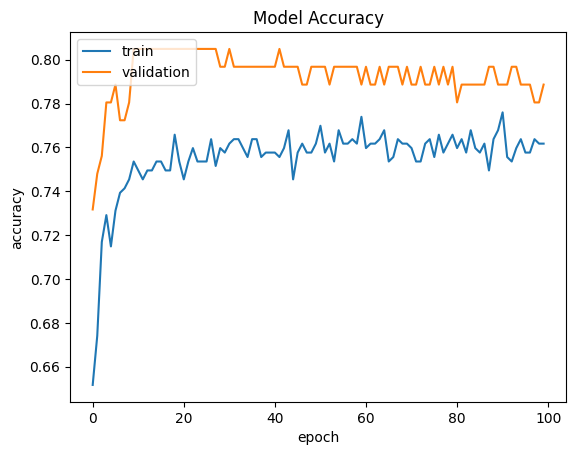

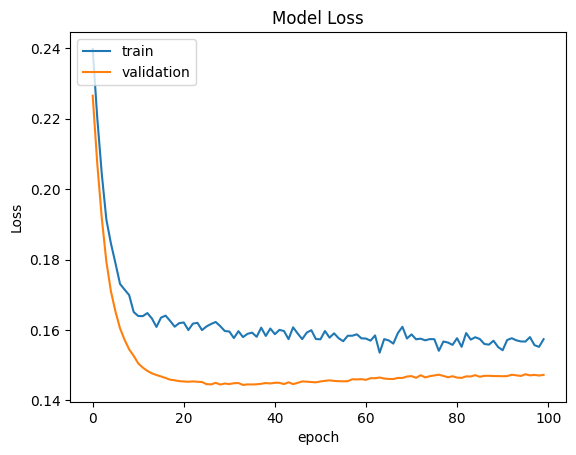

In [ ]:

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()
#plt.plot()

In [ ]:

y_test.shape



(154, 1)

5/5 [==============================] - 0s 3ms/step


 the confussion of matrix of this model is
 [[82 17]
 [19 36]] 



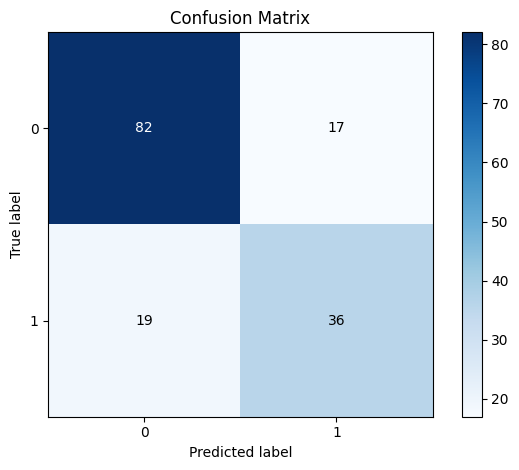




The Accurancy score is  0.7662337662337663


In [ ]:
y_pred = model_cnn.predict(x_test) 
y_pred = y_pred  > 0.5
y_pred = y_pred.astype(int)
y_pred = y_pred.reshape(-1,1)
y_test = y_test.astype(int)





## confussion matrix 
cm = confusion_matrix(y_test , y_pred)
classes = np.unique(y_test)

print("\n\n the confussion of matrix of this model is\n" , cm ,"\n")

# forse lo lelimino ueta parte di codice 
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()



ac = accuracy_score(y_test, y_pred)
print("\n\n\nThe Accurancy score is " , ac)  # the start of accuracy was 0.7272

In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)




Precision: 0.6792452830188679
Recall: 0.6545454545454545
F1-score: 0.6666666666666666


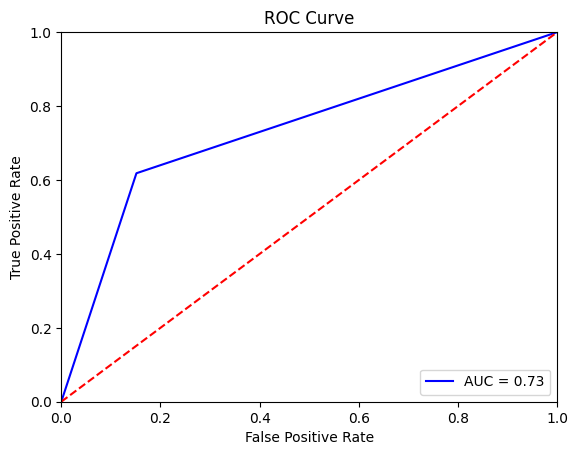

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# fpr = false positive rate, trp  =true positviet rate and also called recall
fpr, tpr, threholds = roc_curve(y_test, y_pred)
roc_auc =roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### RNN

In [ ]:

timesteps = 1
x_train_3d  = np.reshape(x_train, (x_train.shape[0], timesteps, x_train.shape[1]))
x_train_3d.shape

print(x_train.shape)
print(y_train.shape)



model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units = 50, return_sequences= True, input_shape = (timesteps , x_train.shape[1])),
    tf.keras.layers.SimpleRNN(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(units = 50, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)])


model_rnn.compile(optimizer = "adam" , loss= "mean_squared_error")
model_rnn.fit(x_train_3d , y_train, epochs = 100, batch_size = 32)

8/8 [==============================] - 1s 3ms/step

The confusiion mattrix of this rnn is



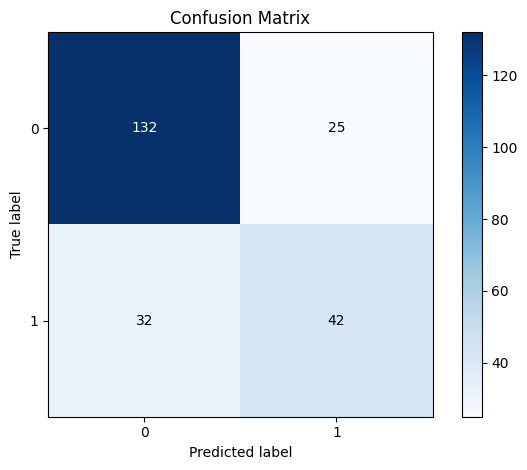



The accuarcy o fthe this RNN model is  0.7532467532467533


In [ ]:
x_test_3d = np.reshape(x_test, (x_test.shape[0], timesteps , x_test.shape[1]))
y_pred = model_rnn.predict(x_test_3d)
y_pred = (y_pred >  0.5)
y_pred = y_pred.reshape(y_pred.shape[0] , -1).reshape(-1,1)



# confussion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)


print("\nThe confusiion mattrix of this rnn is\n")


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()




## accuracy score
ac_rnn = accuracy_score(y_test, y_pred)
print("\n\nThe accuarcy o fthe this RNN model is ", ac_rnn)

In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Precision: 0.6268656716417911
Recall: 0.5675675675675675
F1-score: 0.5957446808510638


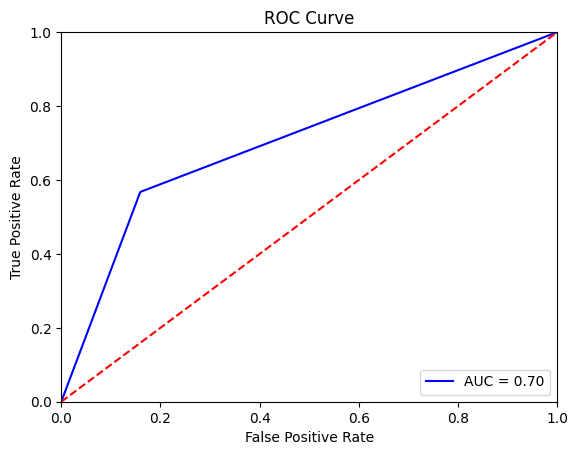

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# fpr = false positive rate, trp  =true positviet rate and also called recall
fpr, tpr, threholds = roc_curve(y_test, y_pred)
roc_auc =roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### LSTM

In [ ]:
x_train_3d.shape

(491, 1, 8)

In [ ]:
# I will leave here bu tmaybe I willnotto optimization for lstm leave like that for now 


timesteps = 1
x_train_3d  = np.reshape(x_train, (x_train.shape[0], timesteps, x_train.shape[1]))
x_valid_3d  = np.reshape(x_val, (x_val.shape[0], timesteps, x_val.shape[1]))



def create_lstm_model(units = 16): 
  model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = units, return_sequences= True, input_shape = (timesteps , x_train.shape[1])),
    tf.keras.layers.LSTM(units = units, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units = units, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)])
  model_LSTM.compile(optimizer = Adam(learning_rate = 0.0001) , loss = "mean_squared_error", metrics = ["accuracy"])
  return   model_LSTM



model_LSTM = KerasRegressor(model = create_lstm_model, units = 16)

hyperparamter = {"batch_size":  [16, 32,64],
                 "units"  : [16,32,64],
                 "loss" :  []
                
              }

grid_search = GridSearchCV(estimator = model_LSTM , param_grid=hyperparamter, cv = 3 )



history  = grid_search.fit(x_train_3d, y_train , validation_data = (x_valid_3d, y_val))


In [ ]:
# print the best hyperparameters and their corresponding score
print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'batch_size': 16}
Best score: nan


In [ ]:

timesteps = 1
x_train_3d  = np.reshape(x_train, (x_train.shape[0], timesteps, x_train.shape[1]))
x_valid_3d  = np.reshape(x_val, (x_val.shape[0], timesteps, x_val.shape[1]))
#x_valid_3d.shape

print(x_train.shape)
print(y_train.shape)



model_LSTM = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units = 32, return_sequences= True, input_shape = (timesteps , x_train.shape[1])),
    tf.keras.layers.LSTM(units = 64, return_sequences = True),
    tf.keras.layers.LSTM(units = 64, return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)])


model_LSTM.compile(optimizer = Adam(learning_rate = 0.0001) , loss = "mean_squared_error",  metrics = ["accuracy"])
history = model_LSTM.fit(x_train_3d , y_train, epochs = 100, batch_size = 32, validation_data = (x_valid_3d, y_val) )

(491, 8)
(491, 1)
Epoch 1/100
16/16 [==============================] - 9s 107ms/step - loss: 0.3469 - accuracy: 0.6517 - val_loss: 0.3373 - val_accuracy: 0.6585
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3422 - accuracy: 0.6517 - val_loss: 0.3327 - val_accuracy: 0.6585
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3373 - accuracy: 0.6517 - val_loss: 0.3281 - val_accuracy: 0.6585
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3326 - accuracy: 0.6517 - val_loss: 0.3233 - val_accuracy: 0.6585
Epoch 5/100
16/16 [==============================] - 0s 16ms/step - loss: 0.3278 - accuracy: 0.6517 - val_loss: 0.3183 - val_accuracy: 0.6585
Epoch 6/100
16/16 [==============================] - 0s 15ms/step - loss: 0.3220 - accuracy: 0.6517 - val_loss: 0.3131 - val_accuracy: 0.6585
Epoch 7/100
16/16 [==============================] - 0s 14ms/step - loss: 0.3167 - accuracy: 0.6517 - val_loss: 0.3074 - val_accu

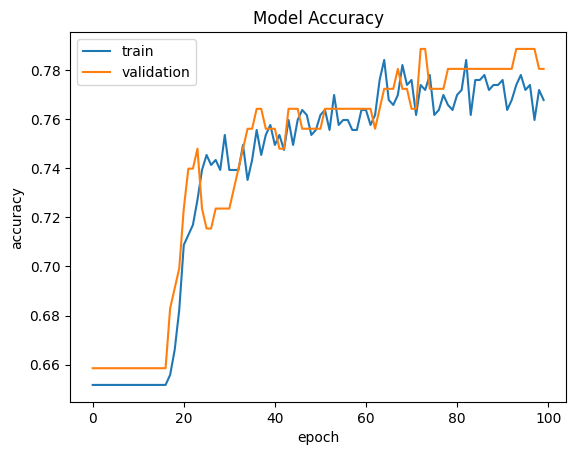

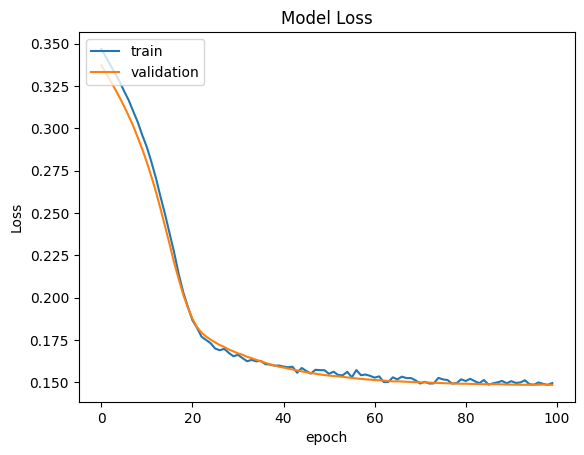

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()
#plt.plot()

5/5 [==============================] - 0s 5ms/step

The confusiion mattrix of this rnn is



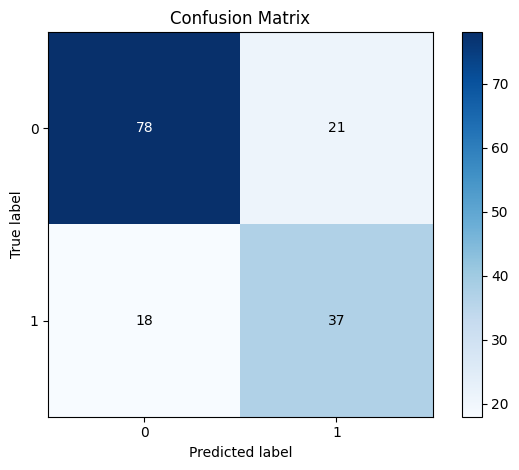



The accuarcy o fthe this LSTM model is  0.7467532467532467


In [ ]:
x_test_3d = np.reshape(x_test, (x_test.shape[0], timesteps , x_test.shape[1]))
y_pred = model_LSTM.predict(x_test_3d)
y_pred = (y_pred >  0.5)
y_pred = y_pred.reshape(y_pred.shape[0] , -1).reshape(-1,1)





# confussion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)


print("\nThe confusiion mattrix of this rnn is\n")


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()




## accuracy score
ac_rnn = accuracy_score(y_test, y_pred)
print("\n\nThe accuarcy o fthe this LSTM model is ", ac_rnn)



In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Precision: 0.6379310344827587
Recall: 0.6727272727272727
F1-score: 0.6548672566371682


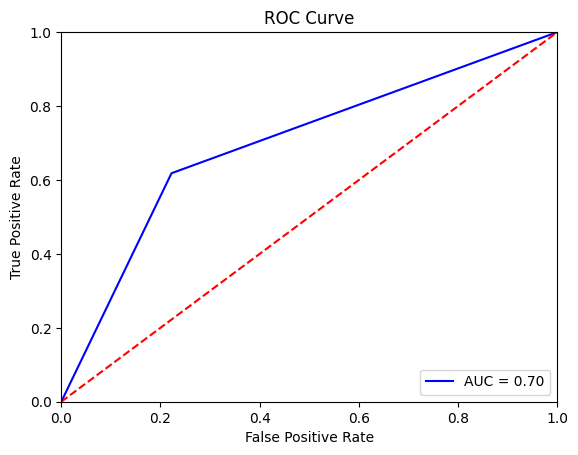

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# fpr = false positive rate, trp  =true positviet rate and also called recall
fpr, tpr, threholds = roc_curve(y_test, y_pred)
roc_auc =roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### GRU model  


In [ ]:
from tensorflow.keras.layers import GRU, Dense

x_train = np.array(x_train)
timesteps = 1
x_train = x_train.reshape(x_train.shape[0], timesteps, -1)

x_val = np.array(x_val)
timesteps = 1
x_val = x_val.reshape(x_val.shape[0], timesteps, -1)

model_GRU = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units = 32, return_sequences= True, input_shape = (1,8)),
    tf.keras.layers.GRU(units = 64, return_sequences= True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units = 64, return_sequences= True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units = 1)])

# earl stopping#  overfiting 
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20)


model_GRU.compile(optimizer = Adam(learning_rate= 0.001) , loss= "mean_squared_error", metrics = "accuracy")
history = model_GRU.fit(x_train , y_train, epochs = 100, batch_size = 32, validation_data = (x_val , y_val), callbacks = [early_stopping])

Epoch 1/100
16/16 [==============================] - 11s 100ms/step - loss: 0.2630 - accuracy: 0.6538 - val_loss: 0.1855 - val_accuracy: 0.7154
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1741 - accuracy: 0.7434 - val_loss: 0.1544 - val_accuracy: 0.7480
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1612 - accuracy: 0.7678 - val_loss: 0.1506 - val_accuracy: 0.7724
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.1602 - accuracy: 0.7699 - val_loss: 0.1527 - val_accuracy: 0.7642
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.1620 - accuracy: 0.7617 - val_loss: 0.1499 - val_accuracy: 0.7805
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1518 - accuracy: 0.7780 - val_loss: 0.1501 - val_accuracy: 0.7805
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: 0.1575 - accuracy: 0.7719 - val_loss: 0.1508 - val_accuracy: 0.7642
Epoc

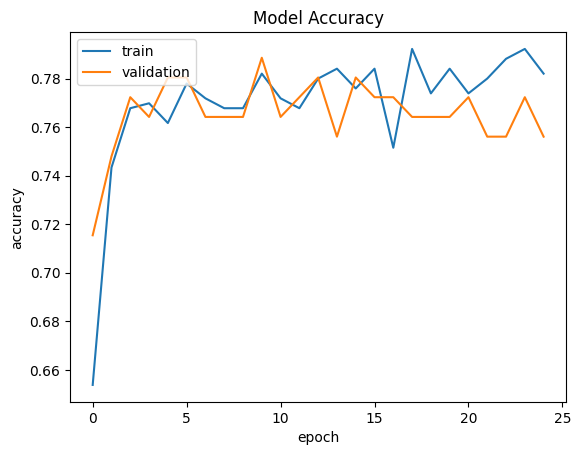

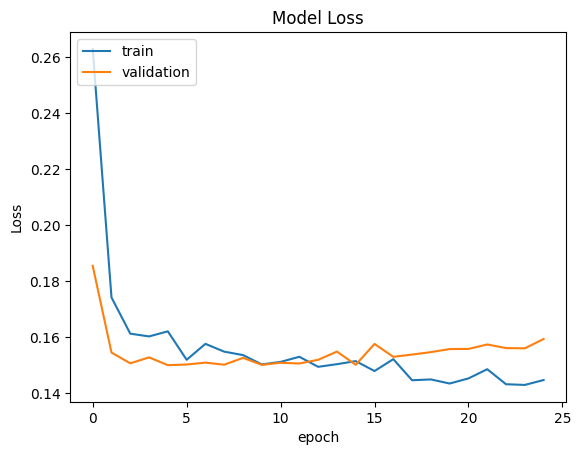

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

5/5 [==============================] - 0s 4ms/step

The confusiion mattrix of this GRU is



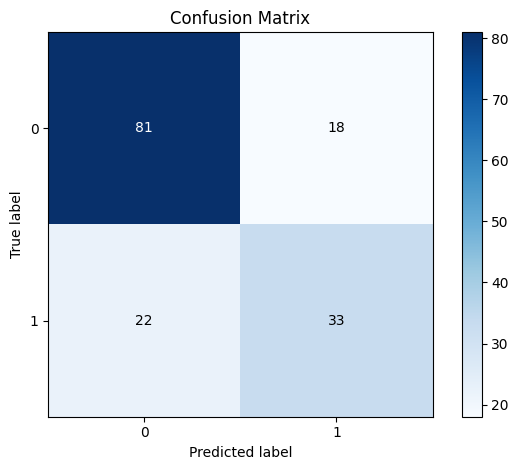



The accuarcy o fthe this GRU model is  0.7402597402597403


In [ ]:
x_test_3d = np.reshape(x_test, (x_test.shape[0], timesteps , x_test.shape[1]))
y_pred = model_GRU.predict(x_test_3d)
y_pred = (y_pred >  0.5)
y_pred = y_pred.reshape(y_pred.shape[0] , -1).reshape(-1,1)



# confussion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)


print("\nThe confusiion mattrix of this GRU is\n")


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()




## accuracy score
ac_rnn = accuracy_score(y_test, y_pred)
print("\n\nThe accuarcy o fthe this GRU model is ", ac_rnn)




In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Precision: 0.6470588235294118
Recall: 0.6
F1-score: 0.6226415094339622


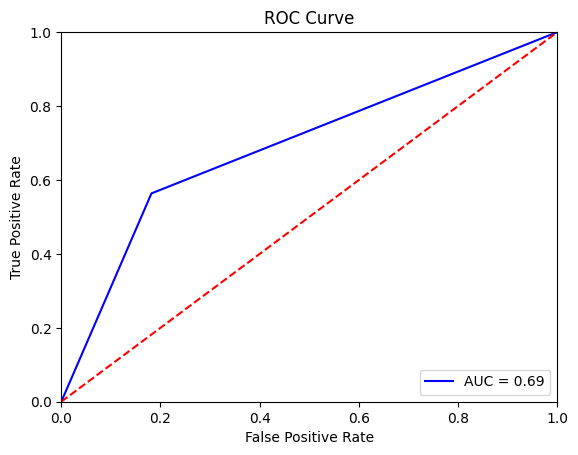

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


# fpr = false positive rate, trp  =true positviet rate and also called recall
fpr, tpr, threholds = roc_curve(y_test, y_pred)
roc_auc =roc_auc_score(y_test, y_pred)


plt.plot(fpr, tpr, color='blue', label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Autoencoders 


In [ ]:
x_test.shape

(154, 8)

In [ ]:
# # concatenate the train set and val set because I do not need label for this model 
# REMEMBER to run just once not more
x_train = x_train.reshape(491,8) 
x_train = np.concatenate((x_train, y_train), axis = 1)
x_test = x_test.reshape(154,8) 
x_test = np.concatenate((x_test, y_test), axis = 1)
x_val = x_val.reshape(123,8)
x_val =  np.concatenate((x_val, y_val), axis = 1)

x_val.shape

(123, 9)

In [ ]:
# SECODM AUTOENCDER,, THIS i POST ON REORT




class Classifier(tf.keras.Model):
  def __init__(self):
    super(Classifier, self).__init__()
    self.fc1 = tf.keras.layers.Dense(units=9, input_dim=9, activation='sigmoid')
    self.fc2 = tf.keras.layers.Dropout(0.5)
    self.fc3= tf.keras.layers.Dense(units=9, activation=None)
    self.fc4 = tf.keras.layers.Dense(units=1, activation='sigmoid')
  
  def call(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    return x

cls = Classifier()
cls.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
history = cls.fit(x_train, y_train,epochs = 100, batch_size =32, validation_data =  (x_val, y_val))

Epoch 1/100
16/16 [==============================] - 1s 24ms/step - loss: 1.4091 - accuracy: 0.4114 - val_loss: 1.1366 - val_accuracy: 0.3415
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 1.1616 - accuracy: 0.4318 - val_loss: 0.9099 - val_accuracy: 0.3415
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 1.0189 - accuracy: 0.4644 - val_loss: 0.7444 - val_accuracy: 0.4797
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.8247 - accuracy: 0.5723 - val_loss: 0.6400 - val_accuracy: 0.6260
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.7219 - accuracy: 0.5682 - val_loss: 0.5775 - val_accuracy: 0.7236
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.6729 - accuracy: 0.6354 - val_loss: 0.5439 - val_accuracy: 0.7724
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.7063 - accuracy: 0.5906 - val_loss: 0.5233 - val_accuracy: 0.7886
Epoch 8/100


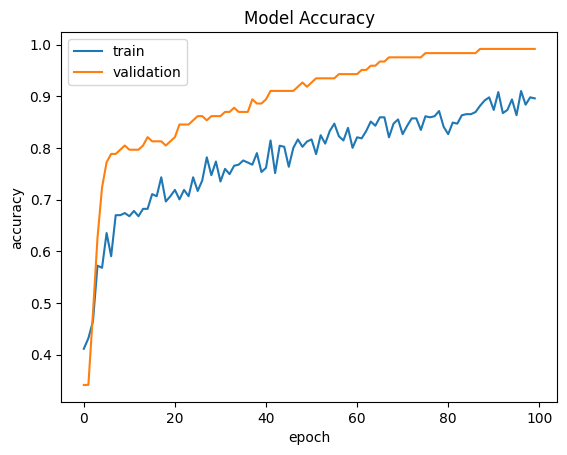

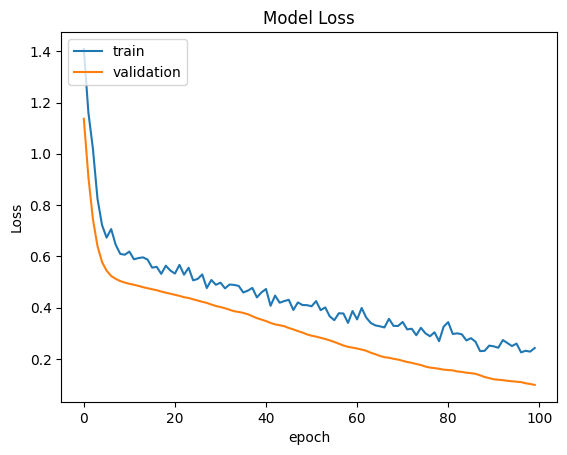

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend(["train" , "validation"],loc = "upper left")
plt.show()

In [ ]:

y_pred = cls.predict(x_test)
y_pred = (y_pred >  0.5)
y_pred[:10]


5/5 [==============================] - 0s 3ms/step


array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

5/5 [==============================] - 0s 3ms/step

The confusiion mattrix of this Autoecoder is



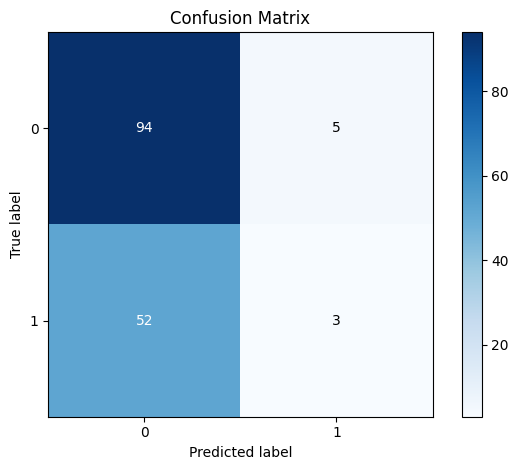



The accuarcy of this Autoecoder model is  0.6298701298701299


In [ ]:

y_pred = cls.predict(x_test)
y_pred = (y_pred >  0.5)
#y_pred = y_pred.reshape(y_pred.shape[0] , -1).reshape(-1,1)



# confussion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)


print("\nThe confusiion mattrix of this Autoecoder is\n")


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()




## accuracy score
ac_rnn = accuracy_score(y_test, y_pred)
print("\n\nThe accuarcy of this Autoecoder model is ", ac_rnn)


 

In [ ]:
from sklearn.metrics import precision_score,  recall_score, f1_score



# y_test is the true labels of the dataset
# y_pred is the predicted labels of the dataset

#how well avoid false positive
precision = precision_score(y_test, y_pred)
print("Precision:", precision)


# how well avoid the false negative snesity and recall 
recall  = recall_score(y_test, y_pred)
print("Recall:", recall)



# mean beatwene the recall and the precision 
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Precision: 0.375
Recall: 0.05454545454545454
F1-score: 0.09523809523809523


In [ ]:
#firts autoencoder
# run just once if more it will  increse x_train[1] #



input_layer = tf.keras.layers.Input(shape=(9,))
encoded_layer = tf.keras.layers.Dense(4, activation ="sigmoid")(input_layer)
decoded_layer =  tf.keras.layers.Dense(9, activation='sigmoid')(encoded_layer)

# Build the autoencoder model
autoencoder_model =  tf.keras.models.Model(input_layer, decoded_layer)        

autoencoder_model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
history = autoencoder_model.fit(x_train, x_train,epochs = 100, batch_size =32, validation_data =  (x_val, y_val))


# Use the encoder part of the trained autoencoder to extract meaningful features
encoder = tf.keras.models.Model(input_layer, encoded_layer)
encoded_data = encoder.predict(x_test)
encoded_data[:10]

Epoch 1/100


ValueError: ignored

In [ ]:
class SAE(tf.keras.Model):
  def __init__(self):
    super(SAE, self).__init__()
    self.fc1 = tf.keras.layers.Dense(units=20, input_dim=9, activation='sigmoid')
    self.fc2 = tf.keras.layers.Dense(units=10, activation='sigmoid')
    self.fc3 = tf.keras.layers.Dense(units=20, activation='sigmoid')
    self.fc4 = tf.keras.layers.Dense(units=9, activation=None)
  
  def call(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)
    return x




In [ ]:
#from tensorflow.keras.optimizers import RMSprop as RMSpropLegacy
## magari dopo lo cambiao  emeto notramle

sae = SAE()
criterion = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

In [ ]:
cls.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])
history = cls.fit(x_train, y_train,epochs = 100, batch_size =32, validation_data =  (x_val, y_val))

Epoch 1/100
16/16 [==============================] - 4s 58ms/step - loss: 0.2555 - accuracy: 0.6517 - val_loss: 0.2500 - val_accuracy: 0.3984
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.2504 - accuracy: 0.3483 - val_loss: 0.2503 - val_accuracy: 0.3415
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.2501 - accuracy: 0.5214 - val_loss: 0.2501 - val_accuracy: 0.6667
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.2500 - accuracy: 0.6599 - val_loss: 0.2500 - val_accuracy: 0.4715
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.2500 - accuracy: 0.4094 - val_loss: 0.2500 - val_accuracy: 0.6016
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.7169 - val_loss: 0.2500 - val_accuracy: 0.6829
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.6640 - val_loss: 0.2500 - val_accuracy: 0.5935
Epoch 8/

In [ ]:
## evalautet the model test 
y_pred = cls.predict(x_test)
test_loss = sae.evaluate(X_test, X_test)

ValueError: ignored

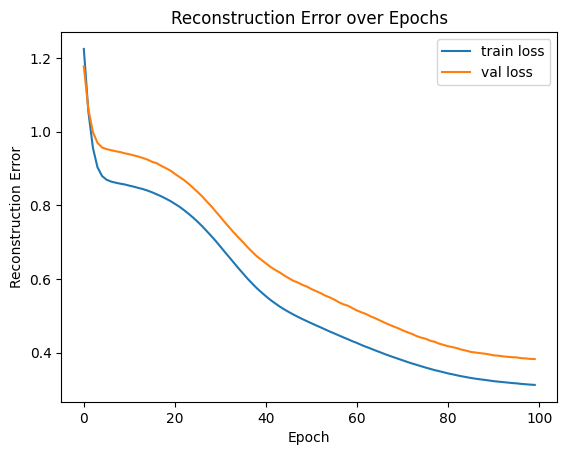

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the reconstruction error over epochs
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('Reconstruction Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

In [ ]:
encoder = tf.keras.Sequential([
    sae.fc1,
    sae.fc2
])

encoded_data    = encoder(X_test)
print(encoded_data)




tf.Tensor(
[[0.31720755 0.33514267 0.03425259 ... 0.7952025  0.99304324 0.1401608 ]
 [0.09146235 0.3033741  0.0314844  ... 0.47733256 0.99410343 0.2709188 ]
 [0.51154214 0.69048935 0.01250638 ... 0.8406757  0.99069    0.29450634]
 ...
 [0.3172555  0.33521453 0.03424704 ... 0.7953695  0.99303955 0.14007176]
 [0.12586124 0.18670437 0.08301812 ... 0.68552536 0.99401706 0.14717312]
 [0.112597   0.22350422 0.05930728 ... 0.61583674 0.9940477  0.18452592]], shape=(154, 10), dtype=float32)


In [ ]:

#  visualize the reconstructed output and assess the quality of the model's output visually.

decoder = tf.keras.Sequential([
    sae.fc3,
    sae.fc4
])





decoded_data  = decoder(encoded_data)
print(decoded_data)




tf.Tensor(
[[0.69089425 2.1593204  0.8325133  ... 0.45104247 1.1815653  1.0810592 ]
 [0.43603075 2.0589845  0.9836878  ... 0.4798469  0.82785153 1.0441067 ]
 [0.9013658  1.9000763  0.9649947  ... 0.02498281 1.3205421  0.9842288 ]
 ...
 [0.6911551  2.1593113  0.83249533 ... 0.4510439  1.1818144  1.08107   ]
 [0.5357667  2.1788046  0.8448034  ... 0.6392042  0.99916315 1.0864458 ]
 [0.50609696 2.1483564  0.9041676  ... 0.5785333  0.94361985 1.0760318 ]], shape=(154, 9), dtype=float32)


In [ ]:
#  evalaute 
from sklearn.metrics import mean_squared_error 

x_test_flat  = X_test.reshape(X_test.shape[0], -1)
decode_data_flat = decoded_data.numpy().reshape(decoded_data.shape[0], -1)

mse = mean_squared_error(x_test_flat, decode_data_flat)
print("mse" , mse)

mse 4284.936535585666


######more  thing

In [ ]:
test_loss = 0
s = 0.

for i in range(X_test.shape[0]):
  input = tf.Variable(X_test[i]).numpy().reshape(1, 8)
  target = tf.Variable(y_test[i]).numpy().reshape(1, 1)
  if np.sum(target > 0) > 0:
    output = sae(input)
    target = tf.Variable(target).numpy().reshape(1, 1)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    output_masked = tf.multiply(output, tf.cast(target > 0, dtype=tf.float32))
    loss = criterion(output_masked, target)
    mean_corrector = 8 / float(np.sum(target > 0) + 1e-10)
    test_loss += np.sqrt(loss.numpy() * mean_corrector)
    s += 1.
  print('test loss: ' + str(test_loss / s))

In [ ]:
## DO NOT RUN NO

# e code you provided is an example of training a denoising autoencoder using the stochastic gradient descent 
#optimizer with a custom training loop. This type of implementation can be useful for certain situations where more
# control over the training process is needed, or when using non-standard loss functions or other customizations.
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for i in range(X_train.shape[0]):
    input = tf.Variable(X_train[i]).numpy().reshape(1, 8)
    target = input.copy()
    if np.sum(target > 0) > 0:
        with tf.GradientTape() as tape:
            output = sae(input)
            target = tf.Variable(target).numpy().reshape(1, 8)
            target = tf.convert_to_tensor(target, dtype=tf.float32)
            output_masked = tf.multiply(output, tf.cast(target > 0, dtype=tf.float32))
            loss = criterion(output_masked, target)
            mean_corrector = 8 / float(np.sum(target > 0) + 1e-10)
            train_loss += np.sqrt(loss.numpy() * mean_corrector)
            s += 1.
        gradients = tape.gradient(loss, sae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, sae.trainable_variables))

print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss / s))


In [ ]:
!pip install MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.1-py3-none-any.whl size=10609 sha256=e8593dbbc817b763b15c5c4e3c8d510928b3fd5b1195ae1d8b83934740d1e837
  Stored in directory: /root/.cache/pip/wheels/b4/aa/7a/d9a88098f7877aa95dd4f227fe614f75773654baa39b47bba6
Successfully built MiniSom


In [ ]:
#from minisom import MiniSom


# Define the som grid
som_width  = 10 
som_height = 10
input_dim = x_train.shape[1]




# initialize the som
som = MiniSom(som_width, som_height, input_dim , sigma = .3, learning_rate =  .5)
# sigma: The initial standard deviation of the Gaussian neighborhood function. This parameter controls the extent of the neighborhood around each neuron during training. A higher value of sigma allows for larger neighborhoods, while a lower value results in smaller, more focused neighborhoods.
# The learning rate is a parameter in the SOM algorithm that controls how quickly the weights of the SOM neurons are updated during training. A higher learning rate means that the weights will be updated more quickly, leading to faster convergence and learning. However, if the learning rate is set too high, the weights can oscillate and converge to a suboptimal solution. On the other hand, a lower learning rate means that the weights will be updated more slowly, resulting in slower convergence, but with more stability and less risk of converging to a suboptimal solution.
# In machine learning, convergence refers to the process where a model has learned the underlying patterns in the training data and has stopped learning from further training. When a model converges, it means that the weights and biases of the model have been adjusted to the point where the model can make accurate predictions on new, unseen data. At this point, further training may not improve the performance of the model, and it is important to monitor the convergence of the model during training to avoid overfitting.



# train the the som on data
som.train_random(x_train, 100)

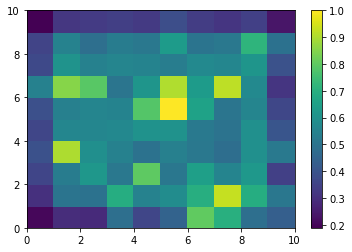

In [ ]:

# visualize the som
from pylab import pcolor, colorbar , plot
pcolor(som.distance_map().T)
colorbar()


In [ ]:
# assign the input dta to the som neurons 
mapped = som.win_map(x_train)

In [ ]:
# extract the cluster form the som 
cluster = []
for i in range(som_width): 
  for j in range(som_height):
    if len(mapped[(i, j)])  > 0: 
      cluster.append(mapped[(i,j)])


for i , cluster in enumerate(cluster) : 
  print(f"Cluster{i+ 1 } has {len(cluster)} samples")

    
  


In [ ]:
# import the data set and split the data
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# scale the dtaa set
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train)

In [ ]:
## cobevr the data in tensor
# The tf.convert_to_tensor() function is used to create a new tf.Tensor object from a Python list or NumPy array. The dtype argument specifies the data type of the new tensor (in this case, tf.float32)
training_set  = tf.convert_to_tensor(X_train, dtype = tf.float32)
test_set = tf.convert_to_tensor(X_test , dtype =tf.float32  )

training_set = tf.squeeze(training_set)

print(len(test_set))



154


In [ ]:
class RBM():
  def __init__(self, nv, nh) :
    self.W = tf.Variable(tf.random.normal([nv, nh], 0.0 , 0.1))
    self.a = tf.Variable(tf.zeros((nh)), tf.float32)
    self.b = tf.Variable(tf.zeros((nv)), tf.float32)

    # tf.Variable are differnt thenpython variabule becauseh they cna change during training
    #init initlize #  self.W = initlizes the RBM weights 
    # self.a = hidden bias
    # self.b = visible bias // 
    # nv and nh arguments corresponf the number of visible and hidden units in the rbm 
  
  def sample_h(self, x) : # , the sample_h function computes the probabilities of the hidden units being activated, given the visible units. 

    wx = tf.matmul(x, self.W) + self.a# thery : this line computes the weighted sum of the visible units and the weights between the visible and hidden layers.
    #explain the of code wx :  this line compute the activation of the hidden units by the taking the dot product(Given two vectors x and y: x · y = x1 * y1 + x2 * y2 + ... + xn * yn) 
    #of the visible units x and the matrix of W(weight)  and adding an hidden bias.
    # the result is a matrix of shape  (batch_size, num_hidden_units) where the batch size is the numeber of training example in the input data and num_hidden is the number of hidden units
   
    p_h_given_v = tf.nn.softmax(wx) # this line applies the sigmoid function to this weighted  sum, which gives us the probabilities of the  hidden units being activated, given the visible units 
    # the result matrix p_h_given_v has the same shape as wx
   
   # tf.random.uniform(tf.shape(tf.shape(p_h_given_v))) # This line generates a matrix of uniform random values with the same shape as p_h_given_v.
   
    #tf.sign(p_h_given_v - tf.random.uniform(tf.shape(p_h_given_v)))
    # This line subtracts the random matrix from p_h_given_v, takes the sign of the difference,
    # and returns a binary matrix where each element is either 0 or 1. This step is used to sample the 
    #hidden units stochastically based on their activation probabilities.
  
    h = tf.nn.relu(tf.sign(p_h_given_v - tf.random.uniform(tf.shape(p_h_given_v))))
    # This line applies the rectified linear unit (ReLU) activation function to the sampled binary matrix h.
    # The purpose of this step is to set all negative values in h to zero, which effectively means that the hidden units
    # are either fully activated (1) or completely inactive (0).
  
    return p_h_given_v, h
    # This line returns both the activation probabilities p_h_given_v and the sampled binary matrix h.
    # The activation probabilities are used in the training phase to compute the gradients of the RBM model 
    #parameters, while the sampled binary matrix is used in the testing phase to generate new samples from the RBM model.
  




  def sample_v(self, y): # This method is responsible for sampling the visible units given the hidden units.
  # The input y is a tensor representing the activation probabilities of the hidden units.
    wy = tf.matmul(y, self.W, transpose_b = True) + self.b  # calculates the dot product of y and the transpose of the weight matrix W
    p_v_given_h = tf.nn.softmax(wy) #  The tf.nn.sigmoid() function is used to calculate the probabilities of the visible units.
    v  = tf.nn.relu(tf.sign(p_v_given_h -  tf.random.uniform(tf.shape(p_v_given_h))))
    # Then, we sample binary values from these probabilities using the tf.sign() 
    #function and random uniform values generated by tf.random.uniform(tf.shape(p_v_given_h)). 
    #The tf.nn.relu() function is used to threshold the values obtained from tf.sign() and clip any 
    #negative values to zero.
    return p_v_given_h, v
    #Finally, we return both the probabilities p_v_given_h and the sampled binary matrix v. 
    #These values are used in different ways during training and testing phases 

  def train(self, v0, vk, ph0, phk, lr=0.1):
    # This function is used to update the RBM model parameters (weights and biases) based on the gradients of the model parameters computed during the training phase.

    #This is the definition of the train method for the RBM class. It takes in four arguments: v0, vk, ph0, and phk,
    # which are tensors representing the input data, the reconstructed data, the probabilities of the hidden units given the input,
    # and the probabilities of the hidden units given the reconstructed data, respectively. 
    #The lr parameter is the learning rate for the training algorithm.

   # v0 = tf.reshape(v0, [])

    # v0 and vk are input data to the RBM model. v0 is the initial set of visible units and vk is the reconstructed
    # set of visible units obtained after k steps of Gibbs sampling. In other words, v0 is the input data, and vk is the data obtained after passing it through the RBM model 
    #and then using it to sample the hidden units and reconstruct the visible units. 

    #ph0: The probability of the hidden units given the input data v0.
    #phk: The probability of the hidden units after k sampling steps, where k is usually a small number like 1 or 2.
    # the difference between ph0 and phk is used to update the model parameters during the training phase, so that the model becomes better at representing the input data.


    self.W.assign_add(lr * (tf.matmul(v0, ph0, transpose_a=True) - tf.matmul(vk, phk, transpose_a=True)))
    # This line of code updates the weights (W) of the RBM using the Contrastive Divergence algorithm.
    # It calculates the difference between the outer product of the input data (v0) and the activation probabilities
    # of hidden units (ph0) and the outer product of the reconstructed input data (vk) and the activation probabilities
    # of hidden units (phk). Then, it multiplies this difference by the learning rate (lr) and adds the result to the current 
    # value of the weight matrix (self.W) to update it.
    # In summary, this line of code updates the weight matrix of the RBM using the difference between the outer products of input data
    # and activation probabilities of hidden units for the original input data and the reconstructed input data. This difference is scaled by 
    #the learning rate and added to the weight matrix to update it.


    self.b.assign_add(lr * tf.reduce_mean(v0 - vk, 0))
      # This line updates the bias of the visible units (b) in the RBM model based on the difference between the expected values of the visible units (v0)
      # and the reconstructed values of the visible units (vk), multiplied by a learning rate (lr). The reduction mean function computes the mean of the 
      #difference along the 0th axis, which corresponds to the batch axis. This updates the bias values such that the difference between the expected and 
      #reconstructed values is minimized during training.
    self.a.assign_add(lr * tf.reduce_mean(ph0 - phk, 0))
      # This line updates the biases of the hidden units (a) based on the difference between the activation probabilities of the hidden units obtained from the input (ph0) and those obtained from the reconstructed output (phk), which is an estimate of the negative gradient of the log-likelihood of the model with respect to the biases.
      #In other words, this update is based on the difference between the expected hidden unit activations given the input (ph0) and the expected hidden unit activations given the reconstructed output (phk), which represents how much the model has learned to reconstruct the input data. The learning rate (lr) determines how fast or slow the biases are updated based on this difference.


      ## reall important: 
      # The bias term in a neural network is a learnable parameter that is added to the weighted sum of the input to each neuron. The purpose of the bias term is to shift the activation function of the neuron to the left or right, allowing the network to better fit the training data.
      #In the context of an RBM, the visible and hidden units have different roles, and therefore different bias terms. The visible units represent the input data, while the hidden units learn features or representations of the input data. In order to learn these representations, the hidden units need to have a different activation function than the visible units. This is why the bias terms for the visible and hidden units are set differently.
      #Additionally, the bias term for the visible units is usually set to the log probability of the input data, while the bias term for the hidden units is set to zero. This helps to ensure that the model is able to represent the input data properly and allows for more efficient sampling of new data points.






#x_train_np = np.array(x_train)
#x_train_np.size  = 3028

# In this code snippet, nv refers to the number of visible nodes in the
# Restricted Boltzmann Machine (RBM), which is equal to the number of input
# features in the training data. nh refers to the number of hidden nodes in the RBM,
# which is a hyperparameter and can be set to any value based on the requirements of 
#the problem. Here, nh is set to 100.



nh =  3
nv = len(training_set[0])
rbm = RBM(nv, nh)


#training_set = tf.reshape( training_set , shape= ( 1, 8))
print(training_set)

tf.Tensor(
[[ 0.908329    0.9156937   0.44912368 ...  0.37852648  0.677404
   1.699558  ]
 [ 0.03644676 -0.75182194 -0.47230104 ... -0.50667226 -0.07049698
  -0.96569186]
 [-1.1260629   1.387632    1.0634068  ...  2.5409405  -0.11855488
  -0.88240284]
 ...
 [ 0.03644676 -0.8462096  -0.21634972 ... -0.9492717  -0.9565644
  -1.048981  ]
 [ 2.0708387  -1.1293726   0.24436264 ... -0.26640406 -0.5000144
   0.11706589]
 [ 0.32707417  0.47521785  0.6538847  ... -4.0727587   0.52121586
   2.948894  ]], shape=(614, 8), dtype=float32)


In [ ]:
nb_epoch = 30
# nb_epoch is the number of training epochs that the RBM model will run for.


# nb_user = _train 
batch_size  = 100;




for epoch in range(1, nb_epoch + 1):
  train_loss = 0 
  s = 0.
  # For each epoch, the training loss and s 
  #(the number of training instances) are initialized to zero. 


  for id_user in range(0, x_train.shape[0] - batch_size , batch_size): # nb user is referd to the other datset 
    
    vk = training_set[id_user :id_user + batch_size ]
    v0 = training_set[id_user :id_user  +  batch_size]

    #vk and v0 are initialized as tensors containing the same data as the current batch of the training set.
    ph0,_ = rbm.sample_h(v0)
    # ph0 is computed by sampling the hidden layer given the visible layer using the sample_h() method of the RBM class.

    for k in range(10):
      _,hk = rbm.sample_h(vk)
      _,vk = rbm.sample_v(hk)
      vk = tf.where(v0<0, v0, vk)
      #print(vk)
      # For each batch, the inner loop runs for 10 iterations. In each iteration, the hidden layer hk is sampled given the visible layer vk, and then the visible layer vk is resampled given the new hidden layer hk
      # After each sampling step, the missing values of v0 are replaced with the corresponding values from vk.

    phk,_ = rbm.sample_h(vk) # phk is computed by sampling the hidden layer given the new visible layer vk.
    rbm.train(v0, vk, ph0, phk) # he train() method of the RBM class is called to update the weights and biases of the model based on the current batch.

    train_loss += tf.reduce_mean(tf.abs(v0[v0 >= 0] - vk[v0 >= 0]))
    # The training loss is calculated as the mean absolute difference between the non-missing values of v0 and vk.

    s += 1.
  print('epoch: '+str(epoch)+' loss: '+str(train_loss/s)) # y, the training loss for the current epoch is printed.


epoch: 1 loss: tf.Tensor(0.7610693, shape=(), dtype=float32)
epoch: 2 loss: tf.Tensor(0.7662401, shape=(), dtype=float32)
epoch: 3 loss: tf.Tensor(0.7649435, shape=(), dtype=float32)
epoch: 4 loss: tf.Tensor(0.7563398, shape=(), dtype=float32)
epoch: 5 loss: tf.Tensor(0.7704602, shape=(), dtype=float32)
epoch: 6 loss: tf.Tensor(0.76581883, shape=(), dtype=float32)
epoch: 7 loss: tf.Tensor(0.7556485, shape=(), dtype=float32)
epoch: 8 loss: tf.Tensor(0.7676132, shape=(), dtype=float32)
epoch: 9 loss: tf.Tensor(0.7646243, shape=(), dtype=float32)
epoch: 10 loss: tf.Tensor(0.75998926, shape=(), dtype=float32)
epoch: 11 loss: tf.Tensor(0.7589845, shape=(), dtype=float32)
epoch: 12 loss: tf.Tensor(0.7674631, shape=(), dtype=float32)
epoch: 13 loss: tf.Tensor(0.7604025, shape=(), dtype=float32)
epoch: 14 loss: tf.Tensor(0.76760113, shape=(), dtype=float32)
epoch: 15 loss: tf.Tensor(0.76607895, shape=(), dtype=float32)
epoch: 16 loss: tf.Tensor(0.7731237, shape=(), dtype=float32)
epoch: 17 los

In [ ]:
len(test_set.shape)

2

In [ ]:
test_loss = 0 # nitialize the test loss to zero.
s = 0. #  Initialize a counter for the number of test cases.


for id_user in range(len(test_set)): # : Loop through all users in the test set. 

  v = tf.convert_to_tensor(training_set[id_user:id_user+1]) # Get the visible layer for the current user from the training set and convert it to a TensorFlow tensor.
  vt = tf.convert_to_tensor(test_set[id_user:id_user+1]) # Get the corresponding visible layer for the current user from the test set and convert it to a TensorFlow tensor.

  if len(vt[vt>=0]) > 0: # : Check if there are any observed ratings for the current user in the test set (i.e., if there are any non-negative values in vt).

    _,h = rbm.sample_h(v) # : Sample the hidden layer activations h given the visible layer v using the RBM's sample_h() method. The underscore _ is used to discard the first output of the sample_h() method, which is the probability of the hidden units being activated.
    _,v = rbm.sample_v(h) # Sample the visible layer activations v given the hidden layer h using the RBM's sample_v() method. Again, the first output of the method (the probability of the visible units being activated) is discarded.

  
  test_loss += tf.reduce_mean(tf.abs(vt[vt>=0] - v[vt>=0])) #' : Calculate the absolute difference between the observed ratings vt and the predicted ratings v only for the observed ratings (i.e., where vt >= 0) and add it to the test loss. 

  s += 1. #increment of a counter for the number of test cases
  print('test loss: '+str(test_loss/s)) # print loss 

test loss: tf.Tensor(1.6674731, shape=(), dtype=float32)
test loss: tf.Tensor(0.9783981, shape=(), dtype=float32)
test loss: tf.Tensor(0.69613624, shape=(), dtype=float32)
test loss: tf.Tensor(0.6849705, shape=(), dtype=float32)
test loss: tf.Tensor(0.66423404, shape=(), dtype=float32)
test loss: tf.Tensor(0.57719207, shape=(), dtype=float32)
test loss: tf.Tensor(0.61803067, shape=(), dtype=float32)
test loss: tf.Tensor(0.6721232, shape=(), dtype=float32)
test loss: tf.Tensor(0.7488341, shape=(), dtype=float32)
test loss: tf.Tensor(0.73458946, shape=(), dtype=float32)
test loss: tf.Tensor(0.7589916, shape=(), dtype=float32)
test loss: tf.Tensor(0.7913816, shape=(), dtype=float32)
test loss: tf.Tensor(0.7950148, shape=(), dtype=float32)
test loss: tf.Tensor(0.8350801, shape=(), dtype=float32)
test loss: tf.Tensor(0.8139447, shape=(), dtype=float32)
test loss: tf.Tensor(0.82324487, shape=(), dtype=float32)
test loss: tf.Tensor(0.81978416, shape=(), dtype=float32)
test loss: tf.Tensor(nan

In [ ]:
import tensorflow as tf

num_visible = 9
num_hidden = 5

# Define input shape
inputs = tf.keras.Input(shape=(num_visible,))

# Define the bias placeholders
vb = tf.keras.Input(shape=(num_visible,))
hb = tf.keras.Input(shape=(num_hidden,))

# Define the hidden layer placeholder
h = tf.keras.Input(shape=(num_hidden,))

# Define the weights between the visible and hidden layers
w = tf.keras.Input(shape=(num_visible, num_hidden))

# Define the energy function for the Boltzmann machine
def energy(v, h, w, vb, hb):
    v_term = tf.matmul(v, vb)
    h_term = tf.matmul(h, hb)
    w_term = tf.matmul(v, w)
    w_term = tf.matmul(w_term, h, transpose_b=True)
    return tf.reduce_sum(v_term + h_term + w_term)

# Define the probability distribution for the visible layer
def prob_v_given_h(h, w, vb):
    activation = tf.matmul(h, tf.transpose(w)) + vb
    return tf.nn.sigmoid(activation)

# Define the probability distribution for the hidden layer
def prob_h_given_v(v, w, hb):
    activation = tf.matmul(v, w) + hb
    return tf.nn.sigmoid(activation)

# Define the Gibbs sampling step
def gibbs_step(v, w, hb):
    h_sample = tf.round(prob_h_given_v(v, w, hb))
    v_sample = tf.round(prob_v_given_h(h_sample, w, vb))
    return v_sample, h_sample

# Initialize the weights and biases
curr_w = tf.zeros([num_visible, num_hidden], tf.float32)
curr_vb = tf.zeros([num_visible], tf.float32)
curr_hb = tf.zeros([num_hidden], tf.float32)

# Define the number of iterations and learning rate
num_iterations = 1000
learning_rate = 0.1

# Train the Boltzmann machine using contrastive divergence
for i in range(num_iterations):
    v_sample, h_sample = gibbs_step(inputs, curr_w, curr_hb)
    positive_energy = energy(inputs, h_sample, curr_w, curr_vb, curr_hb)
    negative_energy = energy(v_sample, h_sample, curr_w, curr_vb, curr_hb)
    energy_difference = positive_energy - negative_energy
    curr_w += learning_rate * tf.matmul(tf.transpose(inputs), h_sample) - learning_rate * tf.matmul(tf.transpose(v_sample), h)

